<a href="https://colab.research.google.com/github/somosnlp/recursos-nlp-es/blob/main/aplicaciones_de_los_transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Un recorrido 🤗 por las aplicaciones de los Transformers



En este notebook hacemos un recorrido por las aplicaciones de los Transformers. La arquitectura de los Transformers es muy versátil y permite realizar muchas tareas de PLN con sólo pequeñas modificaciones. Por esta razón se han aplicado a una amplia gama de tareas de PLN como la clasificación, el reconocimiento de entidades con nombre o la traducción.

## Pipeline

Experimentamos con modelos para estas tareas utilizando la API de alto nivel llamada pipeline. El pipeline se encarga de todo el preprocesamiento y devuelve predicciones depuradas. El pipeline se utiliza principalmente para la inferencia, donde aplicamos modelos ajustados a nuevos ejemplos.

<img src="https://github.com/huggingface/workshops/blob/main/luzern-university/images/pipeline.png?raw=1" alt="Alt text that describes the graphic" title="Title text" width=800>

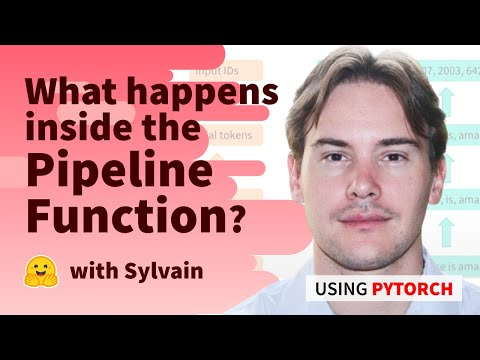

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo('1pedAIvTWXk')

## Configuración

Antes de empezar tenemos que asegurarnos de que tenemos la biblioteca de transformadores instalada, así como el tokenizador de frases que necesitaremos para algunos modelos.

In [ ]:
%%capture
!pip install transformers
!pip install sentencepiece
!pip install gradio

Además, creamos un textwrapper para dar un buen formato a los textos largos.

In [ ]:
import textwrap
wrapper = textwrap.TextWrapper(width=80, break_long_words=False, break_on_hyphens=False)

## Clasificación

Comenzamos estableciendo un texto de ejemplo que nos gustaría analizar con un modelo de Transformer. Esto se parece a los comentarios estándar de los clientes de un Transformer:

In [ ]:
text = """Estimado Amazon, la semana pasada pedí una figura de acción de \
Optimus Prime de su tienda online en Alemania. Desafortunadamente, cuando abrí \
el paquete descubrí con horror que me habían enviado una figura de acción de \
Megatron en su lugar. Como enemigo de toda la vida de los Decepticons, espero \
que puedan entender mi dilema. Para resolver el problema, exijo un intercambio \
de Megatron por la figura de Optimus Prime que pedí. Adjunto copias de mis \
registros relacionados con esta compra. Espero tener noticias suyas pronto. \
Sinceramente, Bumblebee."""

print(wrapper.fill(text))

Estimado Amazon, la semana pasada pedí una figura de acción de Optimus Prime de
su tienda online en Alemania. Desafortunadamente, cuando abrí el paquete
descubrí con horror que me habían enviado una figura de acción de Megatron en su
lugar. Como enemigo de toda la vida de los Decepticons, espero que puedan
entender mi dilema. Para resolver el problema, exijo un intercambio de Megatron
por la figura de Optimus Prime que pedí. Adjunto copias de mis registros
relacionados con esta compra. Espero tener noticias suyas pronto. Sinceramente,
Bumblebee.


Una de las tareas más comunes en PNL y especialmente cuando se trata de textos de clientes es el _análisis de sentimientos_. Nos gustaría saber si un cliente está satisfecho con un servicio o producto y, potencialmente, agregar los comentarios de todos los clientes para elaborar informes.

Para la clasificación de textos, el modelo recibe todas las entradas y realiza una única predicción, como se muestra en el siguiente ejemplo:

<img src="https://github.com/huggingface/workshops/blob/main/luzern-university/images/clf_arch.png?raw=1" alt="Alt text that describes the graphic" title="Title text" width=600>

Podemos conseguirlo configurando un objeto `pipeline` que envuelve un modelo de transformer. Al inicializar necesitamos especificar la tarea. El análisis de sentimientos es un subcampo de la clasificación de textos en el que se da una única etiqueta a un fragmento de texto:

In [ ]:
from transformers import pipeline

sentiment_pipeline = pipeline('text-classification', 
                              model="pysentimiento/robertuito-sentiment-analysis")

Downloading:   0%|          | 0.00/925 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/415M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/334 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/838k [00:00<?, ?B/s]

El modelo `pysentimiento/robertuito-sentiment-analysis` es una pequeña variante de BERT entrenada en documentos españoles.

Verás que la primera vez que ejecutas el modelo se ejecuta una descarga. El modelo se descarga del Hub 🤗. La segunda vez se utilizará el modelo en caché.

Este es un buen momento para aprender del Hub. Vamos a ver un poco de ella
* Plataforma de modelos, datasets y demos.
* Repositorios basados en git.
* Integraciones con >15 bibliotecas.
* Usos en NLP, CV, Audio, etc.
* 27,000 modelos y casi 3,000 datasets.
* Modelos en 180 lenguajes.

Tour de features
* Model card (https://huggingface.co/gpt2)
* Hosting de TensorBoard (https://huggingface.co/bigscience/tr8-104B-logs)
* Reporte de metricas (https://huggingface.co/indonesian-nlp/wav2vec2-indonesian-javanese-sundanese)


Ahora estamos listos para ejecutar nuestro ejemplo a través del pipeline y ver algunas predicciones:

In [ ]:
sentiment_pipeline(text)

[{'label': 'NEG', 'score': 0.754024863243103}]

El modelo predice el sentimiento negativo con una alta confianza, lo que tiene sentido. Se puede ver que el pipeline devuelve una lista de diccionarios con las predicciones. También podemos pasar varios textos al mismo tiempo, en cuyo caso obtendríamos varios diccionarios en la lista para cada texto.

In [ ]:
sentiment_pipeline(["estoy triste", "estoy feliz", "gran workshop!"])

[{'label': 'NEG', 'score': 0.9874746203422546},
 {'label': 'POS', 'score': 0.9797948598861694},
 {'label': 'POS', 'score': 0.9896768927574158}]

## NER (Named Entity Recognition)

Veamos si podemos hacer algo un poco más sofisticado. En lugar de limitarnos a encontrar el sentimiento general, vamos a ver si podemos extraer del texto entidades con nombre, como organizaciones, lugares o personas. Esta tarea se denomina named entity recognition (NER). En lugar de predecir una clase para todo el texto, se predice una clase para cada símbolo, por lo que esta tarea pertenece a la categoría de clasificación de símbolos:

<img src="https://github.com/huggingface/workshops/blob/main/luzern-university/images/ner_arch.png?raw=1" alt="Alt text that describes the graphic" title="Title text" width=550>

Aquí cargamos un modelo español que fue entrenado específicamente para esta tarea:

In [ ]:
ner_pipeline = pipeline('ner', model="mrm8488/bert-spanish-cased-finetuned-ner")

Downloading:   0%|          | 0.00/829 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/419M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/136 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/237k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Cuando pasamos nuestro texto por el modelo obtenemos una larga lista de diccionarios: cada diccionario corresponde a una entidad detectada. Dado que varios tokens pueden corresponder a una sola entidad, podemos aplicar una estrategia de agregación que fusione las entidades si la misma clase aparece en tokens consecutivos:

In [ ]:
entities = ner_pipeline(text)
print(entities)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


[{'entity': 'B-ORG', 'score': 0.9405352, 'index': 3, 'word': 'Amaz', 'start': 9, 'end': 13}, {'entity': 'I-ORG', 'score': 0.7860982, 'index': 4, 'word': '##on', 'start': 13, 'end': 15}, {'entity': 'B-MISC', 'score': 0.95667124, 'index': 15, 'word': 'Opti', 'start': 63, 'end': 67}, {'entity': 'B-PER', 'score': 0.6791238, 'index': 16, 'word': '##mus', 'start': 67, 'end': 70}, {'entity': 'I-MISC', 'score': 0.85575014, 'index': 17, 'word': 'Prim', 'start': 71, 'end': 75}, {'entity': 'I-MISC', 'score': 0.9445444, 'index': 18, 'word': '##e', 'start': 75, 'end': 76}, {'entity': 'B-LOC', 'score': 0.99991536, 'index': 24, 'word': 'Alemania', 'start': 100, 'end': 108}, {'entity': 'B-PER', 'score': 0.8359863, 'index': 46, 'word': 'Mega', 'start': 219, 'end': 223}, {'entity': 'I-MISC', 'score': 0.49507803, 'index': 47, 'word': '##tron', 'start': 223, 'end': 227}, {'entity': 'B-MISC', 'score': 0.9196955, 'index': 60, 'word': 'Dec', 'start': 277, 'end': 280}, {'entity': 'B-PER', 'score': 0.82396275,

In [ ]:
entities = ner_pipeline(text, aggregation_strategy="simple")
print(entities)

[{'entity_group': 'ORG', 'score': 0.86331666, 'word': 'Amazon', 'start': 9, 'end': 15}, {'entity_group': 'MISC', 'score': 0.95667124, 'word': 'Opti', 'start': 63, 'end': 67}, {'entity_group': 'PER', 'score': 0.6791238, 'word': '##mus', 'start': 67, 'end': 70}, {'entity_group': 'MISC', 'score': 0.90014726, 'word': 'Prime', 'start': 71, 'end': 76}, {'entity_group': 'LOC', 'score': 0.99991536, 'word': 'Alemania', 'start': 100, 'end': 108}, {'entity_group': 'PER', 'score': 0.8359863, 'word': 'Mega', 'start': 219, 'end': 223}, {'entity_group': 'MISC', 'score': 0.49507803, 'word': '##tron', 'start': 223, 'end': 227}, {'entity_group': 'MISC', 'score': 0.9196955, 'word': 'Dec', 'start': 277, 'end': 280}, {'entity_group': 'PER', 'score': 0.66209733, 'word': 'Megatron', 'start': 379, 'end': 387}, {'entity_group': 'MISC', 'score': 0.78429735, 'word': 'Optimus Prime', 'start': 405, 'end': 418}, {'entity_group': 'PER', 'score': 0.9850193, 'word': 'Bumblebee', 'start': 541, 'end': 550}]


Limpiemos un poco los outputs:

In [ ]:
for entity in entities:
    print(f"{entity['word']}: {entity['entity_group']} ({entity['score']:.2f})")

Amazon: ORG (0.86)
Opti: MISC (0.96)
##mus: PER (0.68)
Prime: MISC (0.90)
Alemania: LOC (1.00)
Mega: PER (0.84)
##tron: MISC (0.50)
Dec: MISC (0.92)
Megatron: PER (0.66)
Optimus Prime: MISC (0.78)
Bumblebee: PER (0.99)


Parece que el modelo encontró la mayoría de las entidades con nombre, pero se confundió con la clase de los personajes de transformers. Esto no es sorprendente, ya que el conjunto de datos original probablemente no contenía muchos de estos. Por esta razón, tiene sentido seguir afinando un modelo en su conjunto de datos.

## QA (Question-Answering)

Ya hemos visto un ejemplo de clasificación de texto y tokens utilizando transformadores. Sin embargo, hay más tareas interesantes para las que podemos utilizar transformadores. Una de ellas es la respuesta a preguntas. En esta tarea, el modelo recibe una pregunta y un contexto y tiene que encontrar la respuesta a la pregunta dentro del contexto. Este problema puede reformularse como un problema de clasificación: para cada token, el modelo debe predecir si es el principio o el final de la respuesta. Al final podemos extraer la respuesta mirando el intervalo entre el token con la mayor probabilidad de inicio y la mayor probabilidad de final:

<img src="https://github.com/huggingface/workshops/blob/main/luzern-university/images/qa_arch.png?raw=1" alt="Alt text that describes the graphic" title="Title text" width=600>

Puedes imaginar que esto requiere un poco de lógica de pre y post-procesamiento. ¡Menos mal que el pipeline se encarga de todo eso!

In [ ]:
qa_pipeline = pipeline("question-answering", model="mrm8488/distill-bert-base-spanish-wwm-cased-finetuned-spa-squad2-es")

Downloading:   0%|          | 0.00/465 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/419M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/135 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/237k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Let's see if we can ask it what the customer wants:

In [ ]:
question = "¿Qué quiere el cliente?"

outputs = qa_pipeline(question=question, context=text)
outputs

{'answer': 'una figura de acción de Optimus Prime',
 'end': 76,
 'score': 0.1099071055650711,
 'start': 39}

Impresionante, ¡eso suena bien!

## Traducción

Veamos si podemos ir más allá de estas tareas de comprensión del lenguaje natural (NLU) en las que BERT destaca y profundizar en el ámbito generativo. Ten en cuenta que la generación es mucho más cara, ya que solemos generar un token cada vez y necesitamos ejecutarlo varias veces.

<img src="https://github.com/huggingface/workshops/blob/main/luzern-university/images/gen_steps.png?raw=1" alt="Alt text that describes the graphic" title="Title text" width=600>

¿Pero qué pasa si no hay un modelo en el idioma de mis datos? Todavía puedes intentar traducir el texto. El equipo de PNL de Facebook / Meta ha proporcionado modelos 100 pares de idiomas para la traducción. Aquí cargamos uno que traduce del español al portugués:

In [ ]:
translator = pipeline("translation_es_to_pt", model="facebook/m2m100_418M")

Downloading:   0%|          | 0.00/908 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.80G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/272 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.54M [00:01<?, ?B/s]

Downloading:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

Traduzcamos el texto a al portugués:

In [ ]:
text = 'Hoy impartimos un taller sobre Transformers a Accenture Iberia'

In [ ]:
outputs = translator(text, clean_up_tokenization_spaces=True)
print(wrapper.fill(outputs[0]['translation_text']))

Hoje temos um workshop sobre Transformers em Accenture Iberia


Otra aplicación interesante de los modelos de traducción es el aumento de los datos mediante la retraducción.

In [ ]:
translator = pipeline("translation_pt_to_es", model="facebook/m2m100_418M")

In [ ]:
text = outputs[0]['translation_text']
outputs = translator(text, clean_up_tokenization_spaces=True)
print(wrapper.fill(outputs[0]['translation_text']))

Hoy tenemos un taller sobre Transformers en Accenture Iberia


## Clasificación Zero-Shot

Como último ejemplo, veamos una aplicación interesante que muestra la versatilidad de los transformers: la clasificación de zero-shot. En la clasificación de zero-shot, el modelo recibe un texto y una lista de etiquetas candidatas y determina qué etiquetas son compatibles con el texto. En lugar de tener clases fijas, esto permite una clasificación flexible sin ningún dato etiquetado. Suele ser una buena primera línea de base.

In [ ]:
zero_shot_classifier = pipeline("zero-shot-classification",
                                model="MoritzLaurer/mDeBERTa-v3-base-mnli-xnli")

Downloading:   0%|          | 0.00/1.07k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.04G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/463 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.11M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/18.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/156 [00:00<?, ?B/s]

Veamos un ejemplo:

In [ ]:
classes = ["España", "Educación", "PNL"]

In [ ]:
zero_shot_classifier(text, classes)

{'labels': ['España', 'Educación', 'PNL'],
 'scores': [0.9343030452728271, 0.03841708227992058, 0.027279935777187347],
 'sequence': 'Hoje temos um workshop sobre Transformers em Accenture Iberia'}

Esto parece haber funcionado muy bien en este breve ejemplo. Naturalmente, para ejemplos más largos y específicos de un dominio, este enfoque podría sufrir.

## Más pipelines

Hay muchas más pipelines con las que puedes experimentar. Mira la siguiente lista para tener una visión general:

In [ ]:
from transformers import pipelines
for task in pipelines.SUPPORTED_TASKS:
    print(task)

audio-classification
automatic-speech-recognition
feature-extraction
text-classification
token-classification
question-answering
table-question-answering
fill-mask
summarization
translation
text2text-generation
text-generation
zero-shot-classification
conversational
image-classification
image-segmentation
object-detection


Los transformadores no sólo funcionan para la PNL, sino que también pueden aplicarse a otras modalidades. Veamos algunos de ellos.

### Computer Vision

Recientemente, los modelos de Transformers también han entrado en la visión por ordenador. Consulta el modelo DETR en el [Hub](https://huggingface.co/facebook/detr-resnet-101-dc5):

<img src="https://github.com/huggingface/workshops/blob/main/luzern-university/images/object_detection.png?raw=1" alt="Alt text that describes the graphic" title="Title text" width=400>

### Audio

Otra área prometedora es el procesamiento de audio. Especialmente en Speech2Text se han producido recientemente algunos avances prometedores. Véase, por ejemplo, el modelo [wav2vec2](https://huggingface.co/facebook/wav2vec2-base-960h):

<img src="https://github.com/huggingface/workshops/blob/main/luzern-university/images/speech2text.png?raw=1" alt="Alt text that describes the graphic" title="Title text" width=400>

### Table QA

Por último, muchos datos del mundo real siguen estando en forma de tablas. Poder consultar tablas es muy útil y con [TAPAS](https://huggingface.co/google/tapas-large-finetuned-wtq) puedes hacer preguntas tabulares:

<img src="https://github.com/huggingface/workshops/blob/main/luzern-university/images/tapas.png?raw=1" alt="Alt text that describes the graphic" title="Title text" width=400>

## Cache

Cada vez que cargamos un nuevo modelo desde el Hub, éste se almacena en la caché de la máquina en la que se está ejecutando. Si ejecutas estos ejemplos en Colab esto no es un problema ya que el almacenamiento persistente se limpiará después de tu sesión de todos modos. Sin embargo, si ejecutas este cuaderno en tu portátil puede que hayas llenado varios GB de tu disco duro. Por defecto, la caché se guarda en la carpeta `~/.cache/huggingface/transformers`. Asegúrate de borrarla de vez en cuando si tu disco duro empieza a llenarse.